# Implementing a Principal Component Analysis (PCA)

## Introduction

The main purposes of a principal component analysis are the analysis of data to identify patterns and finding patterns to reduce the dimensions of the dataset with minimal loss of information.

Here, our desired outcome of the principal component analysis is to project a feature space (our dataset consisting of $n$ $d$-dimensional samples) onto a smaller subspace that represents our data "well". A possible application would be a pattern classification task, where we want to reduce the computational costs and the error of the parameter estimation by reducing the number of dimensions of our feature space by extracting a subspace that describes our data "best".

### What is a "good" subspace?

Let's assume that our goal is to reduce the dimensions of a $d$-dimensional dataset by projecting it onto a $k$-dimensional subspace (where $k < d$). So, how do we know what size we would choose for $k$, and how do we know if we have a feature space that represents our data "well"? Later, we will compute eigenvectors (the components) from our dataset and collect them in a so-called scatter-matrix (or alternatively calculate them from the covariance matrix). Each of those eigenvectors is associated with an eigenvalue, which tells us about the "length" or "magnitude" of the eigenvectors. If we observe that all the eigenvalues are of very similar magnitude, this is a good indicator that our data is already in a "good" subspace. Or if some of the eigenvalues are much higher than others, we might be interested in keeping only those eigenvectors with the much larger eigenvalues, since they contain more information about our data distribution. Vice versa, eigenvalues that are close to 0 are less informative and we might consider in dropping those when we construct the new feature subspace.

### Summarizing the PCA approach

Listed below are the 6 general steps for performing a principal component analysis, which we will investigate in the following sections.

1. Take the whole dataset consisting of $d$-dimensional samples ignoring the class labels
2. Compute the $d$-dimensional mean vector (i.e. the means for every dimension of the whole dataset)
3. Compute the scatter matrix (alternatively, the covariance matrix) of the whole dataset
4. Compute eigenvectors ($e_1,e_2,...,e_d$) and corresponding eigenvalues ($\lambda_1,\lambda_2,...,\lambda_d$)
5. Sort the eigenvectors by decreasing eigenvalues and choose $k$ eigenvectors with the largest eigenvalues to form a $d \times k$ dimensional matrix $W$ (where every column represents an eigenvector)
6. Use this $d \times k$ eigenvector matrix to transform the samples onto the new subspace. This can be summarized by the mathematical equation: $y=W^T \times x$ (where $x$ is a $d \times 1$-dimensional vector representing one sample, and $y$ is the transformed $k \times 1$-dimensional sample in the new subspace.)

## Generating some 3-dimensional sample data

For the following example, we will generate 40 3-dimensional samples randomly drawn from a multivariate Gaussian distribution.

Here we will assume that the samples stem from two different classes, where one half (i.e. 20) samples of our dataset are labeled $\omega_1$ (class 1) and the other half $\omega_2$ (class 2).

$
\mu_1 = 
\begin{bmatrix}
0 \\
0 \\
0
\end{bmatrix} \quad
\mu_2 =
\begin{bmatrix}
1 \\
1 \\
1
\end{bmatrix} \quad
\text{(sample means)}
$

$
\Sigma_1 =
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix} \quad
\Sigma_2 =
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix} \quad
\text{(covariance matrices)}
$

### Why are we choosing a 3-dimensional sample?

The problem of multi-dimensional data is its visualization, which would make it quite tough to follow our example principal component analysis (at least visually). We could also choose a 2-dimensional sample dataset for the following examples, but since the goal of the PCA in a "Dimensionality Reduction" application is to drop at least one of the dimensions, I find it more intuitive and visually appealing to start with a 3-dimensional dataset that we reduce to a 2-dimensional dataset by dropping 1 dimension.

In [1]:
import numpy as np

mu_vec1 = np.zeros(3)
cov_mat1 = np.eye(3)
class1_sample = np.random.multivariate_normal(mu_vec1, cov_mat1, 20).T
assert class1_sample.shape == (3, 20), "The matrix has not the dimensions 3x20"

mu_vec2 = np.ones(3)
cov_mat2 = np.eye(3)
class2_sample = np.random.multivariate_normal(mu_vec2, cov_mat2, 20).T
assert class2_sample.shape == (3, 20), "The matrix has not the dimensions 3x20"

Using the code above, we created two $3 \times 20$ datasets - one dataset for each class $\omega_1$ and $\omega_2$ - where each column can be pictured as a 3-dimensional vector $x = \begin{pmatrix}x_1 \\ x_2 \\ x_3 \end{pmatrix}$ so that our dataset will have the form

$
X = 
\begin{pmatrix}
x_{1_1} & x_{1_2} & ... & x_{1_{20}}\\
x_{2_1} & x_{2_2} & ... & x_{2_{20}}\\
x_{3_1} & x_{3_2} & ... & x_{3_{20}}\\
\end{pmatrix}
$

Just to get a rough idea how the samples of our two classes $\omega_1$ and $\omega_2$ are distributed, let us plot them in a 3D scatter plot.

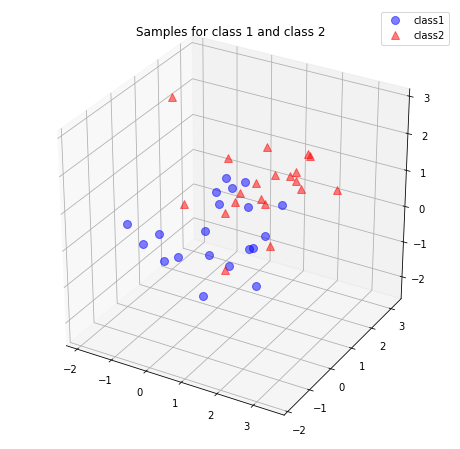

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(class1_sample[0, :], class1_sample[1, :], class1_sample[2, :],
        'o', markersize=8, color='blue', alpha=0.5, label='class1')
ax.plot(class2_sample[0, :], class2_sample[1, :], class2_sample[2, :],
        '^', markersize=8, color='red', alpha=0.5, label='class2')

plt.title('Samples for class 1 and class 2')
ax.legend(loc='upper right')

plt.show()

## 1. Taking the whole dataset ignoring the class labels

Because we don't need class labels for the PCA analysis, let us merge the samples for our 2 classes into on $3 \times 40$-dimensional array.

In [3]:
all_samples = np.concatenate((class1_sample, class2_sample), axis=1)
assert all_samples.shape == (3, 40), "The matrix has not the dimensions 3x40"

## 2. Computing the d-dimensional mean vector

In [4]:
mean_vector = np.mean(all_samples, axis=1).reshape(-1, 1)
mean_vector

array([[0.84295331],
       [0.64766798],
       [0.57691099]])